# 用PSO-RBF算法做模式识别
把模式提取出来的6个特征向量整合成trainData，然后标签给Y，进行训练即可

In [11]:
import time
import matplotlib.pyplot as plt
import math
from scipy.linalg import norm, pinv # 范数(norm)和伪逆(pseudo-inverses)
import random
import numpy as np

In [12]:
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['xtick.color'] = 'w'  #设置横轴刻度颜色为w
plt.rcParams['ytick.color'] = 'w'  
%matplotlib inline

# Cluster

In [13]:
# 聚类的实现
# 数据集形式data=[[],[],...,[]]
# 聚类结果形式result=[[[],[],...],[[],[],...],...]
# 其中[]为一个模式样本，[[],[],...]为一个聚类

def start_cluster(data, t):
    zs = [data[0]]  # 聚类中心集，选取第一个模式样本作为第一个聚类中心Z1
    # 第2步：寻找Z2,并计算阈值T
    T = step2(data, t, zs)
    # 第3,4,5步，寻找所有的聚类中心
    get_clusters(data, zs, T)
    # 按最近邻分类
    result = classify(data, zs, T)
    return result


# 分类
def classify(data, zs, T):
    result = [[] for i in range(len(zs))]
    for aData in data:
        min_distance = T
        index = 0
        for i in range(len(zs)):
            temp_distance = get_distance(aData, zs[i])
            if temp_distance < min_distance:
                min_distance = temp_distance
                index = i
        result[index].append(aData)
    return result


# 寻找所有的聚类中心
def get_clusters(data, zs, T):
    max_min_distance = 0
    index = 0
    for i in range(len(data)):
        min_distance = []
        for j in range(len(zs)):
            distance = get_distance(data[i], zs[j])
            min_distance.append(distance)
        min_dis = min(dis for dis in min_distance)
        if min_dis > max_min_distance:
            max_min_distance = min_dis
            index = i
    if max_min_distance > T:
        zs.append(data[index])
        # 迭代
        get_clusters(data, zs, T)


# 寻找Z2,并计算阈值T
def step2(data, t, zs):
    distance = 0
    index = 0
    for i in range(len(data)):
        temp_distance = get_distance(data[i], zs[0])
        if temp_distance > distance:
            distance = temp_distance
            index = i
    # 将Z2加入到聚类中心集中
    zs.append(data[index])
    # 计算阈值T
    T = t * distance
    return T


# 计算两个模式样本之间的欧式距离
def get_distance(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    n = norm(data1-data2)
    return n

# RBF

In [14]:
class RBF:

    def __init__(self, indim, numCenters, outdim,centers,b):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = centers
        self.beta = []
        for i in range(len(b)):
            self.beta.append(0.5/b[i]**2)
        self.W = np.random.random((self.numCenters, self.outdim))

    def _basisfunc(self, c, d,ci):  #计算高斯函数值
        assert len(d) == self.indim
        b=float(self.beta[ci])
        return np.exp(- b*norm(c - d) ** 2)  #采用高斯函数

    def _calcAct(self, X):  #计算Green矩阵
        G = np.zeros((len(X), self.numCenters), float)   #初始化G
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi, ci] = self._basisfunc(c, x,ci)
        return G

    def train(self, X, Y):
        G = self._calcAct(X)
        self.W = np.dot(pinv(G), Y)

    def test(self, X):
        """ X: matrix of dimensions n x indim """

        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

    def cal_distance(self,X,Y):
        pY=self.test(X)
        d=pY-Y
        d=d**2
        d=sum(d)
        return d

# PSO

In [15]:
# ----------------------PSO参数设置---------------------------------
class PSO():
    def __init__(self, pN, dim, max_iter, data,Y):
        self.w = 0.8
        self.c1 = 2
        self.c2 = 2
        self.r1 = 0.6
        self.r2 = 0.3
        self.pN = pN  # 粒子数量
        self.dim = dim*6  # 搜索维度
        self.max_iter = max_iter  # 迭代次数
        self.X = np.zeros((self.pN, self.dim))  # 所有粒子的位置和速度
        self.V = np.zeros((self.pN, self.dim))
        self.pbest = np.zeros((self.pN, self.dim))  # 个体经历的最佳位置和全局最佳位置
        self.gbest = np.zeros((1, self.dim))
        self.p_fit = np.zeros(self.pN)  # 每个个体的历史最佳适应值
        self.fit = 1e10  # 全局最佳适应值
        self.data = data
        self.Y=Y

    # ---------------------计算宽度值-----------------------------
    def calbeta(self, result, centers):
        di=0
        dikv=[]
        for i in range(len(result)):
            for j in range(len(result[i])):
                di+=(norm(result[i][j]-centers[i]))**2
        di=np.sqrt(di)
        for i in range(len(centers)):
            for j in range(i+1,len(centers)):
                dikv.append(norm(centers[i]-centers[j]))
        dik=min(dikv)
        return dik-di


    # ---------------------目标函数Sphere函数-----------------------------
    def calFitness(self, x):
        # sum = 0
        # length = len(x)
        # x = x ** 2
        # for i in range(length):
        #     sum += x[i]
        if(x[0]>1 or x[0]<0):
            x[0]=0.1
        result = start_cluster(self.data, x[0])
        centers = []
        for i in range(len(result)):
            #print("----------第" + str(i + 1) + "个聚类----------",result[i])
            #y=0
            center=np.zeros(5)
            for j in range(len(result[i])):
                center+=np.array(result[i][j])
                #y+=self.Y[self.data.index(result[i][j])]
            center/=len(result[i])
            #y/=len(result[i])
            centers.append(center)
        b = self.calbeta(result,centers)
        centers = []
        b=[]
        for i in range(int(self.dim/6)):
            temp = x[i * 6:(i + 1) * 6 - 1]
            centers.append(temp)
            temp = x[(i + 1) * 6 - 1]
            b.append(temp)
        rbf = RBF(5, int(self.dim/6), 1,centers,b)
        rbf.train(self.data, self.Y)
        fitness = rbf.cal_distance(self.data, self.Y)
        #print('fitness:',fitness)

        return fitness

    # ---------------------初始化种群----------------------------------
    def init_Population(self):
        for i in range(self.pN):
            for j in range(self.dim):
                if((self.dim+1)%6==0):
                    self.X[i][j] = random.uniform(0.0012, 0.002)
                    self.V[i][j] = random.uniform(-1, 1) * 0.001
                else:
                    self.X[i][j] = random.uniform(0.0012, 0.5)
                    self.V[i][j] = random.uniform(-1, 1)*0.01
            self.pbest[i] = self.X[i]
            tmp = self.calFitness(self.X[i])
            self.p_fit[i] = tmp
            if (tmp < self.fit):
                self.fit = tmp
                self.gbest = self.X[i]

# ----------------------部署最优RBF----------------------------------
    def layoutBest(self):
        centers = []
        b = []
        for i in range(int(self.dim / 6)):
            temp = self.gbest[i*6:(i+1)*6-1]
            centers.append(temp)
            temp = self.gbest[(i+1)*6-1]
            b.append(temp)
        dim=int(self.dim / 6)
        rbf = RBF(5, dim, 1, centers, b)
        rbf.train(self.data, self.Y)
        return rbf

# ----------------------返回最优layout----------------------------------
    def getBestLayout(self):
        return self.gbest

# ----------------------更新粒子位置----------------------------------
    def iterator(self):
        fitness = []
        for t in range(self.max_iter):
            for i in range(self.pN):  # 更新gbest\pbest
                temp = self.calFitness(self.X[i])
                if (temp < self.p_fit[i]):  # 更新个体最优
                    self.p_fit[i] = temp
                    self.pbest[i] = self.X[i]
                    if (self.p_fit[i] < self.fit):  # 更新全局最优
                        self.gbest = self.X[i]
                        self.fit = self.p_fit[i]
            for i in range(self.pN):
                self.V[i] = self.w * self.V[i] + self.c1 * self.r1 * \
                            (self.pbest[i] - self.X[i]) + \
                            self.c2 * self.r2 * (self.gbest - self.X[i])
                self.X[i] = self.X[i] + self.V[i]
            fitness.append(self.fit)
            print(self.fit)  # 输出最优值
        return fitness

# PSO-RBF train model

In [16]:
time_start = time.time()
trainData=[[0.91,0.21,0.02,0.04,0.06],[0.88,0.23,0.04,0.03,0.05],[0.90,0.20,0.05,0.03,0.02],
    [0.04,0.98,0.10,0.02,0.02],[0.02,0.97,0.08,0.01,0.01],[0.03,0.99,0.09,0.02,0.02],
    [0.02,0.41,0.43,0.34,0.15],[0.01,0.47,0.40,0.32,0.10],[0.02,0.52,0.41,0.31,0.14],
    [0.01,0.04,0.01,0.01,0.03],[0.02,0.03,0.06,0.04,0.02],[0.02,0.03,0.05,0.03,0.02]]
Y=[1,1,1,2,2,2,3,3,3,4,4,4]
maxi=50
my_pso = PSO(pN=12, dim=5, max_iter=maxi,data=trainData,Y=Y)
my_pso.init_Population()
fitness = my_pso.iterator()
time_end = time.time()
print('训练耗时：', time_end - time_start)

0.1099084466083321
0.0195415972306868
0.0195415972306868
0.0195415972306868
0.008426054171505777
0.008426054171505777
0.004264636728294951
0.004264636728294951
0.0017492736478814288
0.0017492736478814288
0.0017492736478814288
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008783442894563273
0.0008662338392944495
0.0008662338392944495
0.0008662338392944495
0.0008662338392944495
0.0008662338392944495
0.0008662338392944495
0.0008358315267976851
0.0008358315267976851
0.0008358315267976851
0.0008358315267976851
0.0008293902226303406
0.0008264319768726187
0.0008264319768726187
0.0008264319768726187
0.0008264319768726187
0.000825403143144295
0.0008252379782239825
0.0008252379782239825
0.0007936550452250582
0.0007935900409747165
0.000787773228363295
0.000783980894172539
0.00077

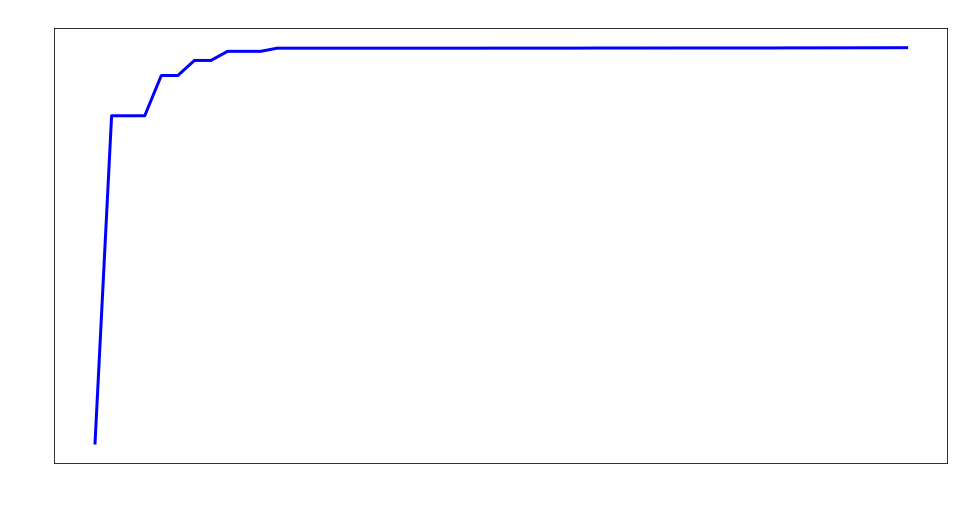

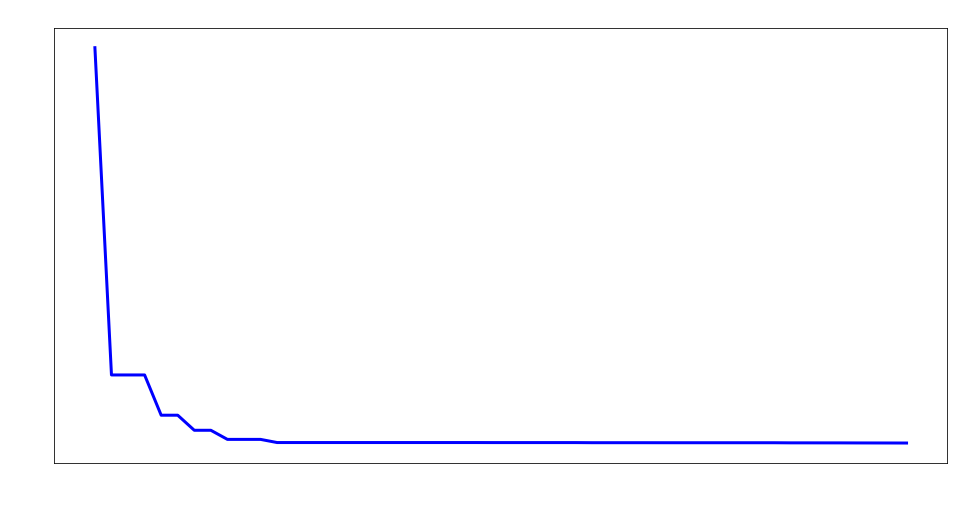

In [28]:
plt.rcParams['figure.figsize'] = (16,8)
plt.figure(1)
plt.title("Figure1",size=20, color='w')
plt.xlabel("iterations", size=14,color='w')
plt.ylabel("accuracy", size=14,color='w')
t = np.array([t for t in range(0, maxi)])
fitness = np.array(fitness)
plt.plot(t, 1-fitness, color='b', linewidth=3)
plt.savefig('1.jpg')
plt.show()
acc=1 - fitness
acc
plt.figure(2)
plt.title("Figure2",size=20, color='w')
plt.xlabel("iterations", size=14,color='w')
plt.ylabel("error", size=14,color='w')
plt.plot(t, fitness, color='b', linewidth=3)
plt.savefig('2.jpg')
plt.show()

In [18]:
bestRbf=my_pso.layoutBest()
trainoutcome=bestRbf.test(np.array(trainData))
print()
print('训练结果：')
print(trainoutcome)
print('训练结果（整数）：')
print((np.around(trainoutcome).astype(np.int32)))


训练结果：
[1.01063018 0.99434716 0.99664904 1.99672719 2.01610342 1.98612318
 3.00025709 3.00243101 2.99726026 3.99507154 4.00754279 3.99736081]
训练结果（整数）：
[1 1 1 2 2 2 3 3 3 4 4 4]


# Test

In [19]:
testData=[[0.91,0.18,0.02,0.04,0.06],[0.03,0.97,0.05,0.02,0.02],
        [0.02,0.41,0.43,0.34,0.15],[0.01,0.04,0.02,0.03,0.03]]
testOutcome=bestRbf.test(np.array(testData))
print('测试样本结果：')
print(testOutcome)

# gbest=my_pso.getBestLayout()
# centers = []
# b = []
# for i in range(6):
#     temp = gbest[i * 6:(i + 1) * 6 - 1]
#     centers.append(temp)
#     temp = gbest[(i + 1) * 6 - 1]
#     b.append(temp)
# rbf = RBF(5, 11, 1, centers, b)
# rbf.train(trainData, Y)

测试样本结果：
[1.08103535 1.96466405 3.00025709 4.00507553]


In [20]:
trainData_array = np.array(trainData)
trainData_array.shape

(12, 5)